In [15]:
import sys
import random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import cPickle
# import _pickle as cPickle

from gensim.models import word2vec
from gensim import corpora, models, similarities
import logging
import pdb
from tqdm import tqdm
import re
from collections import Counter
from matplotlib import pyplot as plt

import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
def display_concept(w):
    return re.sub(r'<?/c>', '', w)
def get_line_count(inFile):
    count = -1
    for count, line in enumerate(open(inFile, 'r')):
        pass
    count += 1
    return count

In [3]:
dataset = 'machine_learning'
approach2topconcept2score = {}
topPercent = 0.2 # sample from topPercent phrases from each source 

In [6]:
approach2concept2score = {}

APPROACHES = ['auto', 'textrank', 'kea', 'rake', 'spacy_np', 'StructMineDataPipeline', 'ours']

for approach in tqdm(APPROACHES):
    if approach == 'ours':
        concept2score_file = "/scratch/home/klee/workspace/conceptMining/data/%s/concept_score.txt" % (dataset)
    else:
        # results for spacy_np, nltk are tfidf ranked 
        concept2score_file = "/scratch/home/hwzha/workspace/%s/result/%s/phrase_list_relative.txt" % (approach, dataset)

    concept2score = {}
    topconcept2score = {}
    lineCount = get_line_count(concept2score_file)
    topn = int(topPercent*lineCount)
    for i, l in enumerate(open(concept2score_file)):
        concept, score = l.strip().split('\t')
        concept = concept.replace('_', ' ')
        score = float(score)
        concept2score[concept] = score
        if i < topn:
            topconcept2score[concept] = score
        # concept2score.append((concept, score))

    approach2concept2score[approach] = concept2score
    approach2topconcept2score[approach] = topconcept2score

common_concepts = set.intersection(*[set(concept2score.keys()) for concept2score in approach2concept2score.values()])

 29%|██▊       | 2/7 [00:02<00:05,  1.15s/it]


KeyboardInterrupt: 

In [11]:
# read manual labeled ground truth file
concept_list = []
y_true = []
with open('/scratch/home/hwzha/workspace/evaluation/current/evaluation/%s/ground_truth.txt' % dataset) as fin:
    for line in fin:
        if '\t' in line.strip():
            concept, label = line.strip().split('\t')
            concept_list.append(concept)
            label = int(label)
            y_true.append(label)

In [20]:
approach2measures = {}
for approach in APPROACHES:
    y_scores = [approach2concept2score[approach].setdefault(concept, 0) for concept in concept_list]  
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    approach2measures[approach] = {'precision':precision, 'recall':recall, 'thresholds':thresholds}

KeyError: 'kea'

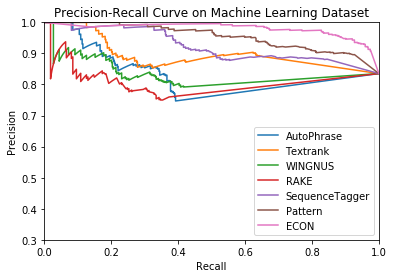

In [122]:
dataset2name = {'database':'Database', 'machine_learning':'Machine Learning', 'pubmed': 'Medicine'}
approachNames = ['AutoPhrase', 'Textrank', 'WINGNUS', 'RAKE', 'SequenceTagger', 'Pattern', 'ECON']
# plotting...
fig, ax = plt.subplots()
for approach, approachName in zip(APPROACHES, approachNames):


    recall = approach2measures[approach]['recall']
    precision = approach2measures[approach]['precision']

    ax.plot(recall,precision, label=approachName) #'k--',color='blue',

ax.legend(loc='lower right')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.title('Precision-Recall Curve on %s Dataset' % dataset2name[dataset])
plt.xlim((0, 1))
plt.ylim((0.3, 1))
plt.savefig('precision_recall_curve_%s_0.3.pdf' % dataset.replace(' ', '_'))


fig.show()

In [123]:
# not_use_concepts = set(rare_counter.keys()).union(set(common_concepts))

# approach2concept2score_difference = {}
# for approach in tqdm(approach2concept2score):
#     concept2score_difference = {concept: score for concept, score in approach2topconcept2score[approach].items() if concept not in not_use_concepts}
#     approach2concept2score_difference[approach] = concept2score_difference

# GENERATE_GROUND_TRUTH = True
# if not GENERATE_GROUND_TRUTH:
#     approach2precision_recall = {}
#     # read back the ...
#     # with open('data/%s/ground_truth_labeled.txt' % dataset) as f:

#     # for approach in APPROACHES:
#     #     precision, recall, _ = precision_recall_curve(y_test, y_score)
#     #     approach2precision_recall[approach] = (precision, recall)
#     # cPickle.dump(approach2precision_recall, 'data/%s/approach2precision_recall.bin' % dataset)
#     # draw roc curve
# else:
#     K = 100
#     concept_pool = set()
#     for approach in approach2concept2score_difference:
#         concept_pool.update(random.sample(approach2concept2score_difference[approach].keys(), K))

#     # output concept_pool for labelling
    
#     concept2explaination = {}
#     with open('/scratch/home/hwzha/workspace/evaluation/%s/ground_truth.txt' % dataset, 'w') as f_out, \
#     open('/scratch/home/hwzha/workspace/evaluation/%s/ground_truth_explanation.txt' % dataset, 'w') as f_out_explanation:
#         for concept in concept_pool:
#             explanation_list = []
#             for approach, concept2score in approach2concept2score.items():
#                 if concept in concept2score:
#                     explanation_list.append('%s:%s' % (approach, round(concept2score[concept], 10)))
#             explanation = ' '.join(explanation_list)
#             concept2explaination[display_concept(concept.strip())] = explanation
# #             explanation = ' '.join([('%s:%s' % (approach, concept2score[concept])) for approach, concept2score in approach2concept2score.items() if concept in concept2score])
#             f_out.write(display_concept(concept.strip()) + '\n')
#             f_out_explanation.write(display_concept(concept.strip())+'\t'+explanation + '\n')

# # test ground truth labels
# with open('/scratch/home/hwzha/workspace/evaluation/%s/ground_truth_labels.txt' % dataset, 'w') as f_out_labels:
#     lineCount = get_line_count('/scratch/home/hwzha/workspace/evaluation/%s/ground_truth.txt' % dataset)
#     for i in range(lineCount):
#         label = np.random.randint(0, 2)
#         f_out_labels.write(str(label))
#         f_out_labels.write('\n')

# y_true = []
# with open('/scratch/home/hwzha/workspace/evaluation/%s/ground_truth_labels.txt' % dataset) as f_in_labels:
#     for label in f_in_labels:
#         label = int(label.strip())
#         y_true.append(label)

# concept_list = []
# with open('/scratch/home/hwzha/workspace/evaluation/%s/ground_truth.txt' % dataset) as f_in:
#     for concept in f_in:
#         concept = concept.strip()
#         concept_list.append(concept)

# approach2concept2score = {approach:{} for approach in APPROACHES}

# with open('/scratch/home/hwzha/workspace/evaluation/%s/ground_truth_explanation.txt' % dataset) as f_in_explanation:
#     for line in f_in_explanation:
#         concept, explanation = line.strip().split('\t')
#         explanation = explanation.split(' ')
#         for l in explanation:
#             approach, score = l.split(':')
#             score = float(score)
#             approach2concept2score[approach][concept] = score

In [124]:
# # avoid sample from low frequency phrases in ours 
# freq_counter = Counter()
# with open('/scratch/home/hwzha/workspace/merge_span/result/%s/freq_in_superspan.txt'%dataset) as fin:
#     for line in fin:
#         phrase, freq = line.strip().split('\t')
#         freq = int(freq)
#         freq_counter[phrase] = freq

# rare_counter = Counter(el for el in freq_counter.elements() if freq_counter[el] < 20)